**Setup GPU**

In [5]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Necessary imports and installations for the implementation of ALBERT Architecture**

In [6]:
import tensorflow_hub as hub
import tensorflow as tf
import os as os
import regex as re
import pandas as pd
import numpy as np
from transformers import AlbertTokenizer
from keras.models import Model
from keras.layers import Flatten
from keras import optimizers
from keras.metrics import MeanSquaredError
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


**Create a AlBERT layer from the tensorflow-hub library**

In [8]:
module_url = 'https://tfhub.dev/tensorflow/albert_en_base/1'
albert_layer = hub.KerasLayer(module_url, trainable=False)

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/albert_en_base/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/albert_en_base/1, Total size: 48.10MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/albert_en_base/1'.


**Functions to preprocess input 10-K documents and output values**

In [ ]:
######## Function to extract the input text from the files ########
def process_inp_doc(path_file) :

  file_text = open(path_file,encoding='utf8').read()

  # remove punctations and digits and remove <PAGE> which was used for page number
  file_data = re.sub(r'[\d$%-:;!]', '', file_text)
  file_data = re.sub(r'<PAGE>', '', file_data)
  file_data = ''.join(file_data)

  return file_data

######## Function to extract the output values from the file ########
def process_out(company_id,output_file):
  
  with open(output_file,'r', encoding='utf-8') as m_file :
    for line in m_file.readlines():
      if company_id == line.split()[1]:
        return line.split()[0]
    print("not found")
  return None

######## Function to pre-process the documents from meta-file of a given year ########
def pre_processing(meta_file,output_file):
  
  with open(meta_file,'r', encoding='utf-8') as m_file :
    
    year = meta_file.split('/')[1].split('.')[0]
    dir_path = os.path.dirname(meta_file) + '/' +year+'.tok'
    data =[]
    for line in m_file.readlines():
      inp_path_file = dir_path +'/'+ line.split()[0] + '.mda'

      # get input sentences from the company document
      inp_sentences = process_inp_doc(inp_path_file)
    
      # get output value for the company
      out_values = float(process_out(line.split()[0],output_file))

      #insert values into the data list
      data.append({'text':inp_sentences,'value':out_values})

  return data

**Functions to get the embeddings(token,masked,segment) and to encode the text for the model**

In [ ]:
######## Function to get the encoded values ######## 
def albert_encode(sentences, tokenizer, MAX_SEQ_LEN=512):

  all_tokens = []
  all_masks = []
  all_segments = []
  for sentence in sentences:
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[-MAX_SEQ_LEN+2:]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]

    token_ids = tokenizer.convert_tokens_to_ids(stokens,)

    ids = token_ids + [0] * (MAX_SEQ_LEN-len(token_ids))
    masks = [1]*len(token_ids) + [0] * (MAX_SEQ_LEN - len(token_ids))
    segments = [0] * (MAX_SEQ_LEN)

    all_tokens.append(ids)
    all_masks.append(masks)
    all_segments.append(segments)

  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

**Data Preprocessing**

In [6]:
with tf.device('/device:GPU:0'):
  ######## extracting text and storing it in dataframes ########
  data_train = pre_processing('10k-sample/2007.meta.txt','10k-sample/2007.logvol.+12.txt')
  data_train.extend(pre_processing('10k-sample/2008.meta.txt','10k-sample/2008.logvol.+12.txt'))
  data_train.extend(pre_processing('10k-sample/2009.meta.txt','10k-sample/2009.logvol.+12.txt'))
  train_df = pd.DataFrame(data_train,columns=['text','value'])
  print("Length of training data",len(data_train))

  data_test = pre_processing('10k-sample/2010.meta.txt','10k-sample/2010.logvol.+12.txt')
  test_df = pd.DataFrame(data_test,columns=['text','value'])
  print("Length of testing data",len(data_test))

  print("SAMPLE INPUT TEXT AND VOLATILITY VALUES")
  print(train_df.sample(5)[['text','value']])
  print(test_df.sample(5)[['text','value']])

Length of training data 7571
Length of testing data 2439
SAMPLE INPUT TEXT AND VOLATILITY VALUES
                                                   text    value
7095  item # management s discussion and analysis of... -2.24259
3719  item # management s discussion and analysis of... -2.87623
4110  item # management s discussion and analysis of... -2.52248
3197  item # management s discussion and analysis of... -2.37330
2586  item # management s discussion and analysis of... -3.15975
                                                   text    value
1656  item # management s discussion and analysis of... -3.45522
1032  item # management s discussion and analysis of... -3.14370
1988  item # management s discussion and analysis of... -3.35437
374   item # management s discussion and analysis of... -3.66717
806   item # management s discussion and analysis of... -3.61892


In [7]:
train_df = train_df.loc[train_df["text"].apply(lambda x: x.split().__len__())>256]
print(train_df)
#88.7%
test_df = test_df.loc[test_df["text"].apply(lambda x: x.split().__len__())>256]
print(test_df)
#89.3%

                                                   text    value
0     item # management s discussion and analysis of... -3.46398
1     item # management s discussion and analysis of... -3.58048
2     item # management s discussion and analysis of... -3.87840
3     item # management s discussion and analysis of... -3.37969
4     item # management s discussion and analysis of... -4.34506
...                                                 ...      ...
7566  item # management s discussion and analysis of... -2.75096
7567  item # management s discussion and analysis of... -3.46372
7568  item # management s discussion and analysis of... -2.94439
7569  item # management s discussion and analysis of... -3.27556
7570  item # management s discussion and analysis of... -3.33055

[6717 rows x 2 columns]
                                                   text    value
0     item # management s discussion and analysis of... -3.87816
1     item # management s discussion and analysis of... -3.45482


In [8]:
######## extracting tokens from dataframes ########
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v1")

MAX_SEQ_LEN = 512

with tf.device('/device:GPU:0'):
  
  #### training 
  # input encoding
  sentences = train_df.text.values
  albert_train_input = albert_encode(sentences, tokenizer, MAX_SEQ_LEN)
  # output values
  albert_train_output = train_df.value.values

  #### test
  # input encoding
  sentences = test_df.text.values
  albert_test_input = albert_encode(sentences, tokenizer, MAX_SEQ_LEN)
  # output values
  albert_test_output = test_df.value.values

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
albert_train_output = np.array(albert_train_output).reshape(len(albert_train_output),1)
albert_test_output = np.array(albert_test_output).reshape(len(albert_test_output),1)
output = np.concatenate((albert_train_output, albert_test_output))
output = scaler.fit_transform(output)
albert_train_output = output[:len(albert_train_input[0])]
albert_test_output = output[-len(albert_test_input[0]):]

**Function that define the model architecture**

In [10]:
def get_model():

  input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="segment_ids")

  custom_objects={'leaky_relu': tf.nn.leaky_relu}

  pooled_output, sequence_output = albert_layer([input_word_ids, input_mask, segment_ids])
  clf_output = pooled_output
  
  net = tf.keras.layers.Dense(64, activation=custom_objects['leaky_relu'])(clf_output)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = Flatten()(net)
  out = tf.keras.layers.Dense(1, activation=custom_objects['leaky_relu'])(net)

  model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

  opt = optimizers.Adam(learning_rate=0.05)
  model.compile(optimizer=opt, loss='mse')

  return model

**Model Summary**

In [11]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 11683584    input_word_ids[0][0]             
                                                                 input_mask[0][0]             

**Fit the Model**

In [12]:
n_splits = 10
epochs = 50
with tf.device('/device:GPU:0'):
  kf = KFold(n_splits=n_splits)
  history =[]
  train_loss=[]
  vald_loss=[]
  fold = 1
  for train_index, test_index in kf.split(albert_train_input[0]):
    
    checkpoint_filepath = 'Albert_results/CheckPoints/albert_checkpoint'+str(fold)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

    train_history = model.fit(
                              [albert_train_input[0][train_index],albert_train_input[1][train_index],albert_train_input[2][train_index]],#input
                              albert_train_output[train_index],#output
                              epochs=epochs, #epochs
                              verbose=1,
                              callbacks=[model_checkpoint_callback]
                          )
    model_best = tf.keras.models.load_model(checkpoint_filepath)
    fold+=1
    loss_T = model_best.evaluate([albert_train_input[0][train_index],albert_train_input[1][train_index],albert_train_input[2][train_index]]
                                       , albert_train_output[train_index], verbose=0)
    loss_V = model_best.evaluate([albert_train_input[0][test_index],albert_train_input[1][test_index],albert_train_input[2][test_index]]
                                      , albert_train_output[test_index], verbose=0)
    print(loss_T,loss_V)
    train_loss.append(loss_T)
    vald_loss.append(loss_V)
    history.append(train_history)  

Train Index:  [ 672  673  674 ... 6714 6715 6716] 

Validation Index:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 

INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


Epoch 2/50
189/189 [==============================] - 201s 1s/step - loss: 3.5883


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


Epoch 3/50
189/189 [==============================] - 202s 1s/step - loss: 2.0609


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


Epoch 4/50
189/189 [==============================] - 202s 1s/step - loss: 0.6695


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


Epoch 5/50
189/189 [==============================] - 202s 1s/step - loss: 0.3710
Epoch 6/50
189/189 [==============================] - 202s 1s/step - loss: 0.1521


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


Epoch 7/50
189/189 [==============================] - 202s 1s/step - loss: 0.1323
Epoch 8/50
189/189 [==============================] - 202s 1s/step - loss: 0.0843


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


Epoch 9/50
189/189 [==============================] - 202s 1s/step - loss: 0.1632
Epoch 10/50
189/189 [==============================] - 202s 1s/step - loss: 0.0819
Epoch 11/50
189/189 [==============================] - 202s 1s/step - loss: 0.0543


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint1/assets


Epoch 12/50
189/189 [==============================] - 208s 1s/step - loss: 0.0708
Epoch 13/50
189/189 [==============================] - 208s 1s/step - loss: 0.0672
Epoch 14/50
189/189 [==============================] - 205s 1s/step - loss: 0.0551
Epoch 15/50
189/189 [==============================] - 208s 1s/step - loss: 0.1147
Epoch 16/50
189/189 [==============================] - 207s 1s/step - loss: 0.0593
Epoch 17/50
189/189 [==============================] - 207s 1s/step - loss: 0.0928
Epoch 18/50
189/189 [==============================] - 207s 1s/step - loss: 0.4524
Epoch 19/50
189/189 [==============================] - 208s 1s/step - loss: 0.2096
Epoch 20/50
189/189 [==============================] - 209s 1s/step - loss: 0.3309
Epoch 21/50
189/189 [==============================] - 207s 1s/step - loss: 0.1756
Epoch 22/50
189/189 [==============================] - 205s 1s/step - loss: 0.1245
Epoch 23/50
189/189 [==============================] - 207s 1s/step - loss: 0.1617
Epoc

INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 2/50
189/189 [==============================] - 204s 1s/step - loss: 0.6177


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 3/50
189/189 [==============================] - 204s 1s/step - loss: 0.5003


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 4/50
189/189 [==============================] - 204s 1s/step - loss: 0.4123


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 5/50
189/189 [==============================] - 205s 1s/step - loss: 0.3283


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 6/50
189/189 [==============================] - 204s 1s/step - loss: 0.2731


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 7/50
189/189 [==============================] - 204s 1s/step - loss: 0.2270


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 8/50
189/189 [==============================] - 204s 1s/step - loss: 0.1844


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 9/50
189/189 [==============================] - 204s 1s/step - loss: 0.1570


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 10/50
189/189 [==============================] - 204s 1s/step - loss: 0.1321


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 11/50
189/189 [==============================] - 204s 1s/step - loss: 0.1133


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 12/50
189/189 [==============================] - 204s 1s/step - loss: 0.1001


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 13/50
189/189 [==============================] - 204s 1s/step - loss: 0.0847


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 14/50
189/189 [==============================] - 204s 1s/step - loss: 0.0849
Epoch 15/50
189/189 [==============================] - 204s 1s/step - loss: 0.0680


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 16/50
189/189 [==============================] - 204s 1s/step - loss: 0.0633


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 17/50
189/189 [==============================] - 204s 1s/step - loss: 0.0648
Epoch 18/50
189/189 [==============================] - 204s 1s/step - loss: 0.0584


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 19/50
189/189 [==============================] - 204s 1s/step - loss: 0.0611
Epoch 20/50
189/189 [==============================] - 204s 1s/step - loss: 0.0707
Epoch 21/50
189/189 [==============================] - 204s 1s/step - loss: 0.0848
Epoch 22/50
189/189 [==============================] - 204s 1s/step - loss: 0.0815
Epoch 23/50
189/189 [==============================] - 204s 1s/step - loss: 0.0942
Epoch 24/50
189/189 [==============================] - 204s 1s/step - loss: 0.3427
Epoch 25/50
189/189 [==============================] - 204s 1s/step - loss: 0.1180
Epoch 26/50
189/189 [==============================] - 204s 1s/step - loss: 0.5626
Epoch 27/50
189/189 [==============================] - 204s 1s/step - loss: 0.1268
Epoch 28/50
189/189 [==============================] - 204s 1s/step - loss: 0.1773
Epoch 29/50
189/189 [==============================] - 204s 1s/step - loss: 0.1301
Epoch 30/50
189/189 [==============================] - 204s 1s/step - loss: 0.3204
Epoc

INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 38/50
189/189 [==============================] - 204s 1s/step - loss: 0.0375


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 39/50
189/189 [==============================] - 204s 1s/step - loss: 0.0348


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 40/50
189/189 [==============================] - 204s 1s/step - loss: 0.0413
Epoch 41/50
189/189 [==============================] - 204s 1s/step - loss: 0.0243


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 42/50
189/189 [==============================] - 204s 1s/step - loss: 0.0379
Epoch 43/50
189/189 [==============================] - 204s 1s/step - loss: 0.0274
Epoch 44/50
189/189 [==============================] - 204s 1s/step - loss: 0.0384
Epoch 45/50
189/189 [==============================] - 204s 1s/step - loss: 0.0279
Epoch 46/50
189/189 [==============================] - 204s 1s/step - loss: 0.0279
Epoch 47/50
189/189 [==============================] - 204s 1s/step - loss: 0.0220


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 48/50
189/189 [==============================] - 204s 1s/step - loss: 0.0203


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 49/50
189/189 [==============================] - 204s 1s/step - loss: 0.0180


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


Epoch 50/50
189/189 [==============================] - 204s 1s/step - loss: 0.0179


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint2/assets


0.014496891759335995 0.015869714319705963
Train Index:  [   0    1    2 ... 6714 6715 6716] 

Validation Index:  [1344 1345 1346 1347 1348 1349 1350 1351 1352 1353 1354 1355 1356 1357
 1358 1359 1360 1361 1362 1363 1364 1365 1366 1367 1368 1369 1370 1371
 1372 1373 1374 1375 1376 1377 1378 1379 1380 1381 1382 1383 1384 1385
 1386 1387 1388 1389 1390 1391 1392 1393 1394 1395 1396 1397 1398 1399
 1400 1401 1402 1403 1404 1405 1406 1407 1408 1409 1410 1411 1412 1413
 1414 1415 1416 1417 1418 1419 1420 1421 1422 1423 1424 1425 1426 1427
 1428 1429 1430 1431 1432 1433 1434 1435 1436 1437 1438 1439 1440 1441
 1442 1443 1444 1445 1446 1447 1448 1449 1450 1451 1452 1453 1454 1455
 1456 1457 1458 1459 1460 1461 1462 1463 1464 1465 1466 1467 1468 1469
 1470 1471 1472 1473 1474 1475 1476 1477 1478 1479 1480 1481 1482 1483
 1484 1485 1486 1487 1488 1489 1490 1491 1492 1493 1494 1495 1496 1497
 1498 1499 1500 1501 1502 1503 1504 1505 1506 1507 1508 1509 1510 1511
 1512 1513 1514 1515 1516 1517 1518

INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint3/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint3/assets


Epoch 2/50
189/189 [==============================] - 202s 1s/step - loss: 0.0186
Epoch 3/50
189/189 [==============================] - 202s 1s/step - loss: 0.0171


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint3/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint3/assets


Epoch 4/50
189/189 [==============================] - 202s 1s/step - loss: 0.0166


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint3/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint3/assets


Epoch 5/50
189/189 [==============================] - 202s 1s/step - loss: 0.0176
Epoch 6/50
189/189 [==============================] - 202s 1s/step - loss: 0.0175
Epoch 7/50
189/189 [==============================] - 202s 1s/step - loss: 0.0172
Epoch 8/50
189/189 [==============================] - 202s 1s/step - loss: 0.0162


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint3/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint3/assets


Epoch 9/50
189/189 [==============================] - 202s 1s/step - loss: 0.0174
Epoch 10/50
189/189 [==============================] - 202s 1s/step - loss: 0.0165
Epoch 11/50
189/189 [==============================] - 201s 1s/step - loss: 0.0175
Epoch 12/50
189/189 [==============================] - 202s 1s/step - loss: 0.0160


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint3/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint3/assets


Epoch 13/50
189/189 [==============================] - 202s 1s/step - loss: 0.0169
Epoch 14/50
189/189 [==============================] - 202s 1s/step - loss: 0.0179
Epoch 15/50
189/189 [==============================] - 202s 1s/step - loss: 0.0161
Epoch 16/50
189/189 [==============================] - 202s 1s/step - loss: 16796.3457
Epoch 17/50
189/189 [==============================] - 202s 1s/step - loss: 4090.5029
Epoch 18/50
189/189 [==============================] - 202s 1s/step - loss: 463.4711
Epoch 19/50
189/189 [==============================] - 202s 1s/step - loss: 210.1165
Epoch 20/50
189/189 [==============================] - 202s 1s/step - loss: 122.6806
Epoch 21/50
189/189 [==============================] - 202s 1s/step - loss: 84.4197
Epoch 22/50
189/189 [==============================] - 202s 1s/step - loss: 58.0590
Epoch 23/50
189/189 [==============================] - 202s 1s/step - loss: 39.8519
Epoch 24/50
189/189 [==============================] - 202s 1s/step - l

INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 2/50
189/189 [==============================] - 203s 1s/step - loss: 0.3149
Epoch 3/50
189/189 [==============================] - 203s 1s/step - loss: 0.5569
Epoch 4/50
189/189 [==============================] - 203s 1s/step - loss: 3.1412
Epoch 5/50
189/189 [==============================] - 203s 1s/step - loss: 0.3460
Epoch 6/50
189/189 [==============================] - 203s 1s/step - loss: 0.4759
Epoch 7/50
189/189 [==============================] - 203s 1s/step - loss: 0.6511
Epoch 8/50
189/189 [==============================] - 203s 1s/step - loss: 1.1210
Epoch 9/50
189/189 [==============================] - 203s 1s/step - loss: 1.3415
Epoch 10/50
189/189 [==============================] - 203s 1s/step - loss: 0.5035
Epoch 11/50
189/189 [==============================] - 203s 1s/step - loss: 1.5952
Epoch 12/50
189/189 [==============================] - 203s 1s/step - loss: 0.4458
Epoch 13/50
189/189 [==============================] - 203s 1s/step - loss: 0.2626


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 14/50
189/189 [==============================] - 203s 1s/step - loss: 0.6065
Epoch 15/50
189/189 [==============================] - 203s 1s/step - loss: 0.9022
Epoch 16/50
189/189 [==============================] - 203s 1s/step - loss: 0.3302
Epoch 17/50
189/189 [==============================] - 203s 1s/step - loss: 0.3726
Epoch 18/50
189/189 [==============================] - 203s 1s/step - loss: 0.4663
Epoch 19/50
189/189 [==============================] - 203s 1s/step - loss: 0.3816
Epoch 20/50
189/189 [==============================] - 203s 1s/step - loss: 0.3661
Epoch 21/50
189/189 [==============================] - 203s 1s/step - loss: 0.1091


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 22/50
189/189 [==============================] - 203s 1s/step - loss: 0.1792
Epoch 23/50
189/189 [==============================] - 203s 1s/step - loss: 0.2010
Epoch 24/50
189/189 [==============================] - 203s 1s/step - loss: 0.2159
Epoch 25/50
189/189 [==============================] - 203s 1s/step - loss: 0.1012


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 26/50
189/189 [==============================] - 203s 1s/step - loss: 0.0885


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 27/50
189/189 [==============================] - 203s 1s/step - loss: 0.1319
Epoch 28/50
189/189 [==============================] - 203s 1s/step - loss: 0.0785


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 29/50
189/189 [==============================] - 203s 1s/step - loss: 0.0670


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 30/50
189/189 [==============================] - 203s 1s/step - loss: 0.0533


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 31/50
189/189 [==============================] - 203s 1s/step - loss: 0.0372


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 32/50
189/189 [==============================] - 203s 1s/step - loss: 0.0402
Epoch 33/50
189/189 [==============================] - 203s 1s/step - loss: 0.0412
Epoch 34/50
189/189 [==============================] - 203s 1s/step - loss: 0.0319


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 35/50
189/189 [==============================] - 203s 1s/step - loss: 0.0217


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 36/50
189/189 [==============================] - 203s 1s/step - loss: 0.0310
Epoch 37/50
189/189 [==============================] - 203s 1s/step - loss: 0.0269
Epoch 38/50
189/189 [==============================] - 203s 1s/step - loss: 0.0232
Epoch 39/50
189/189 [==============================] - 203s 1s/step - loss: 0.0191


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 40/50
189/189 [==============================] - 203s 1s/step - loss: 0.0203
Epoch 41/50
189/189 [==============================] - 203s 1s/step - loss: 0.0196
Epoch 42/50
189/189 [==============================] - 203s 1s/step - loss: 0.0185


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 43/50
189/189 [==============================] - 203s 1s/step - loss: 0.0185
Epoch 44/50
189/189 [==============================] - 203s 1s/step - loss: 0.0177


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 45/50
189/189 [==============================] - 203s 1s/step - loss: 0.0168


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 46/50
189/189 [==============================] - 203s 1s/step - loss: 0.0169
Epoch 47/50
189/189 [==============================] - 203s 1s/step - loss: 0.0168
Epoch 48/50
189/189 [==============================] - 203s 1s/step - loss: 0.0171
Epoch 49/50
189/189 [==============================] - 203s 1s/step - loss: 0.0160


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint4/assets


Epoch 50/50
189/189 [==============================] - 203s 1s/step - loss: 0.0168
0.0190022811293602 0.025119846686720848
Train Index:  [   0    1    2 ... 6714 6715 6716] 

Validation Index:  [2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729
 2730 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743
 2744 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757
 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771
 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785
 2786 2787 2788 2789 2790 2791 2792 2793 2794 2795 2796 2797 2798 2799
 2800 2801 2802 2803 2804 2805 2806 2807 2808 2809 2810 2811 2812 2813
 2814 2815 2816 2817 2818 2819 2820 2821 2822 2823 2824 2825 2826 2827
 2828 2829 2830 2831 2832 2833 2834 2835 2836 2837 2838 2839 2840 2841
 2842 2843 2844 2845 2846

INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint5/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint5/assets


Epoch 2/50
189/189 [==============================] - 203s 1s/step - loss: 0.0185
Epoch 3/50
189/189 [==============================] - 203s 1s/step - loss: 0.0159


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint5/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint5/assets


Epoch 4/50
189/189 [==============================] - 203s 1s/step - loss: 0.0171
Epoch 5/50
189/189 [==============================] - 203s 1s/step - loss: 24123.2363
Epoch 6/50
189/189 [==============================] - 203s 1s/step - loss: 397.7811
Epoch 7/50
189/189 [==============================] - 203s 1s/step - loss: 162.3470
Epoch 8/50
189/189 [==============================] - 203s 1s/step - loss: 103.6087
Epoch 9/50
189/189 [==============================] - 203s 1s/step - loss: 63.7166
Epoch 10/50
189/189 [==============================] - 203s 1s/step - loss: 45.2751
Epoch 11/50
189/189 [==============================] - 203s 1s/step - loss: 32.9163
Epoch 12/50
189/189 [==============================] - 203s 1s/step - loss: 22.8989
Epoch 13/50
189/189 [==============================] - 203s 1s/step - loss: 18.7690
Epoch 14/50
189/189 [==============================] - 203s 1s/step - loss: 14.1302
Epoch 15/50
189/189 [==============================] - 203s 1s/step - loss: 1

INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 2/50
189/189 [==============================] - 203s 1s/step - loss: 0.4456
Epoch 3/50
189/189 [==============================] - 203s 1s/step - loss: 0.2723
Epoch 4/50
189/189 [==============================] - 203s 1s/step - loss: 0.2999
Epoch 5/50
189/189 [==============================] - 203s 1s/step - loss: 0.4893
Epoch 6/50
189/189 [==============================] - 203s 1s/step - loss: 0.1679


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 7/50
189/189 [==============================] - 203s 1s/step - loss: 0.1363


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 8/50
189/189 [==============================] - 203s 1s/step - loss: 0.1343


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 9/50
189/189 [==============================] - 203s 1s/step - loss: 0.0984


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 10/50
189/189 [==============================] - 203s 1s/step - loss: 0.1791
Epoch 11/50
189/189 [==============================] - 203s 1s/step - loss: 0.1869
Epoch 12/50
189/189 [==============================] - 203s 1s/step - loss: 0.0613


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 13/50
189/189 [==============================] - 203s 1s/step - loss: 0.0790
Epoch 14/50
189/189 [==============================] - 203s 1s/step - loss: 0.0754
Epoch 15/50
189/189 [==============================] - 203s 1s/step - loss: 0.0456


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 16/50
189/189 [==============================] - 203s 1s/step - loss: 0.0622
Epoch 17/50
189/189 [==============================] - 203s 1s/step - loss: 0.0464
Epoch 18/50
189/189 [==============================] - 203s 1s/step - loss: 0.0476
Epoch 19/50
189/189 [==============================] - 203s 1s/step - loss: 0.0270


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 20/50
189/189 [==============================] - 203s 1s/step - loss: 0.0238


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 21/50
189/189 [==============================] - 203s 1s/step - loss: 0.0241
Epoch 22/50
189/189 [==============================] - 203s 1s/step - loss: 0.0227


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 23/50
189/189 [==============================] - 203s 1s/step - loss: 0.0252
Epoch 24/50
189/189 [==============================] - 203s 1s/step - loss: 0.0272
Epoch 25/50
189/189 [==============================] - 203s 1s/step - loss: 0.0187


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 26/50
189/189 [==============================] - 203s 1s/step - loss: 0.0186


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 27/50
189/189 [==============================] - 203s 1s/step - loss: 0.0190
Epoch 28/50
189/189 [==============================] - 203s 1s/step - loss: 0.0180


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 29/50
189/189 [==============================] - 203s 1s/step - loss: 0.0193
Epoch 30/50
189/189 [==============================] - 203s 1s/step - loss: 0.0170


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 31/50
189/189 [==============================] - 203s 1s/step - loss: 0.0162


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 32/50
189/189 [==============================] - 203s 1s/step - loss: 0.0163
Epoch 33/50
189/189 [==============================] - 203s 1s/step - loss: 0.0163
Epoch 34/50
189/189 [==============================] - 203s 1s/step - loss: 0.0158


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 35/50
189/189 [==============================] - 203s 1s/step - loss: 0.0155


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 36/50
189/189 [==============================] - 203s 1s/step - loss: 0.0151


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 37/50
189/189 [==============================] - 203s 1s/step - loss: 0.0155
Epoch 38/50
189/189 [==============================] - 203s 1s/step - loss: 0.0149


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint6/assets


Epoch 39/50
189/189 [==============================] - 203s 1s/step - loss: 0.0187
Epoch 40/50
189/189 [==============================] - 203s 1s/step - loss: 0.0156
Epoch 41/50
189/189 [==============================] - 203s 1s/step - loss: 0.0161
Epoch 42/50
189/189 [==============================] - 203s 1s/step - loss: 0.0153
Epoch 43/50
189/189 [==============================] - 203s 1s/step - loss: 0.0157
Epoch 44/50
189/189 [==============================] - 203s 1s/step - loss: 13574.7432
Epoch 45/50
189/189 [==============================] - 203s 1s/step - loss: 1251.5594
Epoch 46/50
189/189 [==============================] - 203s 1s/step - loss: 405.6547
Epoch 47/50
189/189 [==============================] - 203s 1s/step - loss: 199.5303
Epoch 48/50
189/189 [==============================] - 203s 1s/step - loss: 113.0568
Epoch 49/50
189/189 [==============================] - 203s 1s/step - loss: 72.7266
Epoch 50/50
189/189 [==============================] - 203s 1s/step - los

INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 2/50
189/189 [==============================] - 203s 1s/step - loss: 24.1547


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 3/50
189/189 [==============================] - 203s 1s/step - loss: 17.2284


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 4/50
189/189 [==============================] - 203s 1s/step - loss: 12.3016


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 5/50
189/189 [==============================] - 203s 1s/step - loss: 9.2643


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 6/50
189/189 [==============================] - 202s 1s/step - loss: 7.0440


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 7/50
189/189 [==============================] - 202s 1s/step - loss: 5.3185


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 8/50
189/189 [==============================] - 202s 1s/step - loss: 4.2869


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 9/50
189/189 [==============================] - 202s 1s/step - loss: 3.3682


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 10/50
189/189 [==============================] - 202s 1s/step - loss: 2.6286


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 11/50
189/189 [==============================] - 202s 1s/step - loss: 2.0242


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 12/50
189/189 [==============================] - 202s 1s/step - loss: 1.6583


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 13/50
189/189 [==============================] - 202s 1s/step - loss: 1.4513


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 14/50
189/189 [==============================] - 202s 1s/step - loss: 1.1230


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 15/50
189/189 [==============================] - 202s 1s/step - loss: 1.0335


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 16/50
189/189 [==============================] - 202s 1s/step - loss: 0.8068


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 17/50
189/189 [==============================] - 202s 1s/step - loss: 0.6763


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 18/50
189/189 [==============================] - 202s 1s/step - loss: 1.0569
Epoch 19/50
189/189 [==============================] - 202s 1s/step - loss: 2.1787
Epoch 20/50
189/189 [==============================] - 202s 1s/step - loss: 0.4637


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 21/50
189/189 [==============================] - 202s 1s/step - loss: 0.5937
Epoch 22/50
189/189 [==============================] - 202s 1s/step - loss: 1.6670
Epoch 23/50
189/189 [==============================] - 202s 1s/step - loss: 1.4738
Epoch 24/50
189/189 [==============================] - 202s 1s/step - loss: 3.0794
Epoch 25/50
189/189 [==============================] - 202s 1s/step - loss: 0.3190


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 26/50
189/189 [==============================] - 202s 1s/step - loss: 0.2454


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 27/50
189/189 [==============================] - 202s 1s/step - loss: 0.2369


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 28/50
189/189 [==============================] - 202s 1s/step - loss: 0.2290


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 29/50
189/189 [==============================] - 202s 1s/step - loss: 0.3134
Epoch 30/50
189/189 [==============================] - 202s 1s/step - loss: 0.4370
Epoch 31/50
189/189 [==============================] - 202s 1s/step - loss: 0.3588
Epoch 32/50
189/189 [==============================] - 202s 1s/step - loss: 0.5216
Epoch 33/50
189/189 [==============================] - 202s 1s/step - loss: 0.5053
Epoch 34/50
189/189 [==============================] - 202s 1s/step - loss: 0.4401
Epoch 35/50
189/189 [==============================] - 202s 1s/step - loss: 1.9220
Epoch 36/50
189/189 [==============================] - 202s 1s/step - loss: 0.4014
Epoch 37/50
189/189 [==============================] - 202s 1s/step - loss: 1.5244
Epoch 38/50
189/189 [==============================] - 202s 1s/step - loss: 1.0492
Epoch 39/50
189/189 [==============================] - 202s 1s/step - loss: 0.4478
Epoch 40/50
189/189 [==============================] - 202s 1s/step - loss: 0.4058
Epoc

INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 46/50
189/189 [==============================] - 202s 1s/step - loss: 0.2451
Epoch 47/50
189/189 [==============================] - 202s 1s/step - loss: 0.2262
Epoch 48/50
189/189 [==============================] - 202s 1s/step - loss: 0.2757
Epoch 49/50
189/189 [==============================] - 202s 1s/step - loss: 0.1209


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


Epoch 50/50
189/189 [==============================] - 202s 1s/step - loss: 0.1010


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint7/assets


0.14557324349880219 0.16787153482437134
Train Index:  [   0    1    2 ... 6714 6715 6716] 

Validation Index:  [4704 4705 4706 4707 4708 4709 4710 4711 4712 4713 4714 4715 4716 4717
 4718 4719 4720 4721 4722 4723 4724 4725 4726 4727 4728 4729 4730 4731
 4732 4733 4734 4735 4736 4737 4738 4739 4740 4741 4742 4743 4744 4745
 4746 4747 4748 4749 4750 4751 4752 4753 4754 4755 4756 4757 4758 4759
 4760 4761 4762 4763 4764 4765 4766 4767 4768 4769 4770 4771 4772 4773
 4774 4775 4776 4777 4778 4779 4780 4781 4782 4783 4784 4785 4786 4787
 4788 4789 4790 4791 4792 4793 4794 4795 4796 4797 4798 4799 4800 4801
 4802 4803 4804 4805 4806 4807 4808 4809 4810 4811 4812 4813 4814 4815
 4816 4817 4818 4819 4820 4821 4822 4823 4824 4825 4826 4827 4828 4829
 4830 4831 4832 4833 4834 4835 4836 4837 4838 4839 4840 4841 4842 4843
 4844 4845 4846 4847 4848 4849 4850 4851 4852 4853 4854 4855 4856 4857
 4858 4859 4860 4861 4862 4863 4864 4865 4866 4867 4868 4869 4870 4871
 4872 4873 4874 4875 4876 4877 4878 4

INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 2/50
189/189 [==============================] - 204s 1s/step - loss: 0.0771


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 3/50
189/189 [==============================] - 204s 1s/step - loss: 0.0726


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 4/50
189/189 [==============================] - 204s 1s/step - loss: 0.0767
Epoch 5/50
189/189 [==============================] - 204s 1s/step - loss: 0.0455


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 6/50
189/189 [==============================] - 204s 1s/step - loss: 0.0502
Epoch 7/50
189/189 [==============================] - 204s 1s/step - loss: 0.0447


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 8/50
189/189 [==============================] - 204s 1s/step - loss: 0.0439


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 9/50
189/189 [==============================] - 204s 1s/step - loss: 0.0273


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 10/50
189/189 [==============================] - 204s 1s/step - loss: 0.0328
Epoch 11/50
189/189 [==============================] - 204s 1s/step - loss: 0.0275
Epoch 12/50
189/189 [==============================] - 204s 1s/step - loss: 0.0250


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 13/50
189/189 [==============================] - 204s 1s/step - loss: 0.0191


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 14/50
189/189 [==============================] - 204s 1s/step - loss: 0.0198
Epoch 15/50
189/189 [==============================] - 204s 1s/step - loss: 0.0180


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 16/50
189/189 [==============================] - 204s 1s/step - loss: 0.0187
Epoch 17/50
189/189 [==============================] - 204s 1s/step - loss: 0.0178


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 18/50
189/189 [==============================] - 204s 1s/step - loss: 0.0167


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 19/50
189/189 [==============================] - 204s 1s/step - loss: 0.0167


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 20/50
189/189 [==============================] - 204s 1s/step - loss: 0.0158


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 21/50
189/189 [==============================] - 204s 1s/step - loss: 0.0161
Epoch 22/50
189/189 [==============================] - 204s 1s/step - loss: 0.0160
Epoch 23/50
189/189 [==============================] - 204s 1s/step - loss: 0.0159
Epoch 24/50
189/189 [==============================] - 204s 1s/step - loss: 0.0157


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint8/assets


Epoch 25/50
189/189 [==============================] - 204s 1s/step - loss: 0.0161
Epoch 26/50
189/189 [==============================] - 204s 1s/step - loss: 0.0162
Epoch 27/50
189/189 [==============================] - 204s 1s/step - loss: 0.0189
Epoch 28/50
189/189 [==============================] - 204s 1s/step - loss: 0.0173
Epoch 29/50
189/189 [==============================] - 204s 1s/step - loss: 0.0192
Epoch 30/50
189/189 [==============================] - 204s 1s/step - loss: 13355.6895
Epoch 31/50
189/189 [==============================] - 204s 1s/step - loss: 575.5171
Epoch 32/50
189/189 [==============================] - 204s 1s/step - loss: 245.6378
Epoch 33/50
189/189 [==============================] - 204s 1s/step - loss: 135.6810
Epoch 34/50
189/189 [==============================] - 204s 1s/step - loss: 85.2690
Epoch 35/50
189/189 [==============================] - 204s 1s/step - loss: 59.5738
Epoch 36/50
189/189 [==============================] - 204s 1s/step - loss:

INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 2/50
189/189 [==============================] - 204s 1s/step - loss: 1.0928


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 3/50
189/189 [==============================] - 204s 1s/step - loss: 0.9220


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 4/50
189/189 [==============================] - 204s 1s/step - loss: 0.7392


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 5/50
189/189 [==============================] - 204s 1s/step - loss: 0.6570


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 6/50
189/189 [==============================] - 204s 1s/step - loss: 0.5910


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 7/50
189/189 [==============================] - 204s 1s/step - loss: 0.4816


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 8/50
189/189 [==============================] - 204s 1s/step - loss: 0.4356


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 9/50
189/189 [==============================] - 204s 1s/step - loss: 0.4015


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 10/50
189/189 [==============================] - 204s 1s/step - loss: 0.3672


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 11/50
189/189 [==============================] - 204s 1s/step - loss: 0.4256
Epoch 12/50
189/189 [==============================] - 204s 1s/step - loss: 0.2958


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 13/50
189/189 [==============================] - 204s 1s/step - loss: 0.3306
Epoch 14/50
189/189 [==============================] - 204s 1s/step - loss: 1.1391
Epoch 15/50
189/189 [==============================] - 204s 1s/step - loss: 1.2122
Epoch 16/50
189/189 [==============================] - 204s 1s/step - loss: 1.1094
Epoch 17/50
189/189 [==============================] - 204s 1s/step - loss: 0.6708
Epoch 18/50
189/189 [==============================] - 204s 1s/step - loss: 0.6645
Epoch 19/50
189/189 [==============================] - 204s 1s/step - loss: 1.2565
Epoch 20/50
189/189 [==============================] - 204s 1s/step - loss: 1.0533
Epoch 21/50
189/189 [==============================] - 204s 1s/step - loss: 0.1398


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 22/50
189/189 [==============================] - 204s 1s/step - loss: 0.2344
Epoch 23/50
189/189 [==============================] - 204s 1s/step - loss: 0.3561
Epoch 24/50
189/189 [==============================] - 204s 1s/step - loss: 0.2026
Epoch 25/50
189/189 [==============================] - 204s 1s/step - loss: 0.2521
Epoch 26/50
189/189 [==============================] - 204s 1s/step - loss: 0.4475
Epoch 27/50
189/189 [==============================] - 204s 1s/step - loss: 0.4933
Epoch 28/50
189/189 [==============================] - 204s 1s/step - loss: 0.1330


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 29/50
189/189 [==============================] - 204s 1s/step - loss: 0.1417
Epoch 30/50
189/189 [==============================] - 204s 1s/step - loss: 0.1382
Epoch 31/50
189/189 [==============================] - 204s 1s/step - loss: 0.2261
Epoch 32/50
189/189 [==============================] - 204s 1s/step - loss: 0.1519
Epoch 33/50
189/189 [==============================] - 204s 1s/step - loss: 0.1183


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 34/50
189/189 [==============================] - 204s 1s/step - loss: 0.1014


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 35/50
189/189 [==============================] - 204s 1s/step - loss: 0.1115
Epoch 36/50
189/189 [==============================] - 204s 1s/step - loss: 0.0972


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 37/50
189/189 [==============================] - 204s 1s/step - loss: 0.0644


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 38/50
189/189 [==============================] - 204s 1s/step - loss: 0.0506


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 39/50
189/189 [==============================] - 204s 1s/step - loss: 0.0594
Epoch 40/50
189/189 [==============================] - 204s 1s/step - loss: 0.0577
Epoch 41/50
189/189 [==============================] - 204s 1s/step - loss: 0.0379


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 42/50
189/189 [==============================] - 204s 1s/step - loss: 0.0458
Epoch 43/50
189/189 [==============================] - 204s 1s/step - loss: 0.0454
Epoch 44/50
189/189 [==============================] - 204s 1s/step - loss: 0.0308


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 45/50
189/189 [==============================] - 204s 1s/step - loss: 0.0275


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 46/50
189/189 [==============================] - 204s 1s/step - loss: 0.0248


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 47/50
189/189 [==============================] - 204s 1s/step - loss: 0.0238


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint9/assets


Epoch 48/50
189/189 [==============================] - 204s 1s/step - loss: 0.0260
Epoch 49/50
189/189 [==============================] - 204s 1s/step - loss: 0.0253
Epoch 50/50
189/189 [==============================] - 204s 1s/step - loss: 0.0244
0.01654168963432312 0.015557445585727692
Train Index:  [   0    1    2 ... 6043 6044 6045] 

Validation Index:  [6046 6047 6048 6049 6050 6051 6052 6053 6054 6055 6056 6057 6058 6059
 6060 6061 6062 6063 6064 6065 6066 6067 6068 6069 6070 6071 6072 6073
 6074 6075 6076 6077 6078 6079 6080 6081 6082 6083 6084 6085 6086 6087
 6088 6089 6090 6091 6092 6093 6094 6095 6096 6097 6098 6099 6100 6101
 6102 6103 6104 6105 6106 6107 6108 6109 6110 6111 6112 6113 6114 6115
 6116 6117 6118 6119 6120 6121 6122 6123 6124 6125 6126 6127 6128 6129
 6130 6131 6132 6133 6134 6135 6136 6137 6138 6139 6140 6141 6142 6143
 6144 6145 6146 6147 6148 6149 6150 6151 6152 6153 6154 6155 6156 6157
 6158 6159 6160 6161 6162 6163 6164 6165 6166 6167 6168 6169 6170 6171


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


Epoch 2/50
189/189 [==============================] - 202s 1s/step - loss: 0.0219


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


Epoch 3/50
189/189 [==============================] - 202s 1s/step - loss: 0.0200


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


Epoch 4/50
189/189 [==============================] - 202s 1s/step - loss: 0.0168


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


Epoch 5/50
189/189 [==============================] - 201s 1s/step - loss: 0.0176
Epoch 6/50
189/189 [==============================] - 202s 1s/step - loss: 0.0165


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


Epoch 7/50
189/189 [==============================] - 202s 1s/step - loss: 0.0164


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


Epoch 8/50
189/189 [==============================] - 202s 1s/step - loss: 0.0180
Epoch 9/50
189/189 [==============================] - 202s 1s/step - loss: 0.0159


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


INFO:tensorflow:Assets written to: Albert_results/CheckPoints/albert_checkpoint10/assets


Epoch 10/50
189/189 [==============================] - 202s 1s/step - loss: 0.0170
Epoch 11/50
189/189 [==============================] - 202s 1s/step - loss: 0.0170
Epoch 12/50
189/189 [==============================] - 202s 1s/step - loss: 17763.0645
Epoch 13/50
189/189 [==============================] - 201s 1s/step - loss: 850.9902
Epoch 14/50
189/189 [==============================] - 201s 1s/step - loss: 308.1840
Epoch 15/50
189/189 [==============================] - 202s 1s/step - loss: 164.9107
Epoch 16/50
189/189 [==============================] - 202s 1s/step - loss: 101.7538
Epoch 17/50
189/189 [==============================] - 202s 1s/step - loss: 66.5745
Epoch 18/50
189/189 [==============================] - 202s 1s/step - loss: 46.8231
Epoch 19/50
189/189 [==============================] - 202s 1s/step - loss: 32.2225
Epoch 20/50
189/189 [==============================] - 202s 1s/step - loss: 24.7424
Epoch 21/50
189/189 [==============================] - 202s 1s/step - l

**Plot all the folds together**

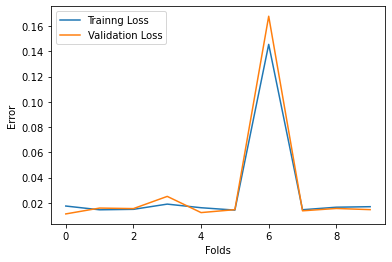

In [13]:
plt.plot(train_loss, label = "Trainng Loss")
plt.plot(vald_loss, label = "Validation Loss")
# naming the x axis 
plt.xlabel('Folds') 
# naming the y axis 
plt.ylabel('Error') 
# function to show the plot 
plt.legend()
plt.savefig('Albert_results/Plots/albert_loss_check.png')

**Predict the Model from the checkpoint**

In [14]:
test_loss = []
with tf.device('/device:GPU:0'):
    
    for i in range(n_splits):

        checkpoint_filepath = 'Albert_results/CheckPoints/albert_checkpoint'+str(i+1) 
        best_model = tf.keras.models.load_model(
                                                checkpoint_filepath, custom_objects=None, compile=True, options=None
                                                )
        predicted = best_model.predict(albert_test_input[0:50])
        
        loss_test = best_model.evaluate([albert_test_input[0],albert_test_input[1],albert_test_input[2]]
                                          , albert_test_output, verbose=0)
        print("Test Errror for the fold ",i+1," is",loss_test )
        
        
        plt.plot(predicted[0:50], label = "Predicted Values")  
        plt.plot(albert_test_output[0:50], label = "Actual Values")
        # naming the x axis 
        plt.xlabel('Test Samples') 
        # naming the y axis 
        plt.ylabel('Output Values') 
        # function to show the plot 
        plt.legend()
        textstr = "Test Errror for the fold "+ str(i+1)+" is "+str(np.round(loss_test,3))
        plt.gcf().text(0, -0.25, textstr, fontsize=14)
        plt.savefig('Albert_results/Plots/albert_fold'+str(i+1)+'.png',bbox_inches='tight')
        plt.clf()

        test_loss.append(loss_test)

Test Errror for the fold  1  is 0.011684637516736984
Test Errror for the fold  2  is 0.020909717306494713
Test Errror for the fold  3  is 0.02167622558772564
Test Errror for the fold  4  is 0.011452443897724152
Test Errror for the fold  5  is 0.02602614276111126
Test Errror for the fold  6  is 0.02057226188480854
Test Errror for the fold  7  is 0.0898866280913353
Test Errror for the fold  8  is 0.02180769108235836
Test Errror for the fold  9  is 0.012698045931756496
Test Errror for the fold  10  is 0.013499819673597813


<Figure size 432x288 with 0 Axes>

Training Loss: 0.029 (0.039)
Validation Loss: 0.031 (0.046)
Test Loss: 0.025 (0.022)


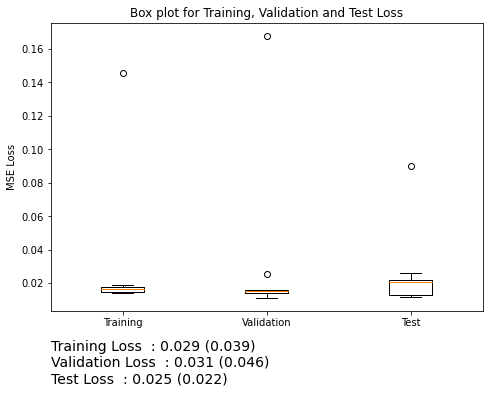

In [15]:
import matplotlib.pylab as plt
data=[]
data.append(train_loss)
data.append(vald_loss)
data.append(test_loss)
  
fig = plt.figure()  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
  
# Creating plot 
ax.boxplot(data)

ax.set_xticklabels(['Training', 'Validation','Test']) 

# naming the y axis 
plt.ylabel('MSE Loss')
plt.title("Box plot for Training, Validation and Test Loss")
textstr ='Training Loss  : '+str(np.round(np.mean(train_loss),3))+' ('+str(np.round(np.std(train_loss),3))+')\n'+'Validation Loss  : '+str(np.round(np.mean(vald_loss),3))+' ('+str(np.round(np.std(vald_loss),3))+')\n'+'Test Loss  : '+str(np.round(np.mean(test_loss),3))+' ('+str(np.round(np.std(test_loss),3))+')'
plt.gcf().text(0, -0.25, textstr, fontsize=14)
# show plot 
plt.savefig('Albert_results/Plots/block_albert.png',bbox_inches='tight')

print('Training Loss: %.3f (%.3f)' % (np.mean(train_loss), np.std(train_loss)))
print('Validation Loss: %.3f (%.3f)' % (np.mean(vald_loss), np.std(vald_loss)))
print('Test Loss: %.3f (%.3f)' % (np.mean(test_loss), np.std(test_loss)))
